In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

import seaborn as sns
import pandas as pd
%matplotlib inline

tf.reset_default_graph()

# np.random.seed(111)
# tf.set_random_seed(111)


In [2]:
def grav_analytical(x, sphere_center, sphere_radius, density_difference):
    """Calculate gravitational effect of a sphere, measured at surface
    
    **Arguments**:
    - 'x' = scalar or np.array: position(s) of observation
    - 'sphere_center' = float: is the vertical position of the center of the sphere (lateral position at origin)
    - 'sphere_radius' = float: sphere radius
    - 'density_difference' = float: density difference to the surrounding domain
    """
    G=6.67e-11 # gravitational constant
    return ((4/3)*np.pi * (sphere_radius**3) * density_difference
            * G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5


In [3]:
sphere_center = 300. #m 
sphere_radius = 100. #m
density_difference = 500. # kg/m^3: density diffrence to surrounding domain
x_domain=np.linspace(-1000,1000,101) #m

In [4]:
# x_obs = 0
x_obs = np.linspace(-250, 250, 11)
grav_all = grav_analytical(x_domain, sphere_center, sphere_radius, density_difference)
grav_obs_array = grav_analytical(x_obs, sphere_center, sphere_radius, density_difference)
noise = norm(0,0.01).rvs(len(grav_obs_array))
grav_obs_array_noise = grav_obs_array +noise
grav_obs_array_noise_sum = np.sum(grav_obs_array_noise)

In [5]:
noise_variance = np.var(noise)

In [6]:
noise_variance

0.00012711821523236086

In [7]:
noise_1 = tf.convert_to_tensor([noise_variance],dtype = tf.float32)

In [8]:
noise_1

<tf.Tensor 'Const:0' shape=(1,) dtype=float32>

In [9]:
noise_tensor = tf.diag(noise_1)

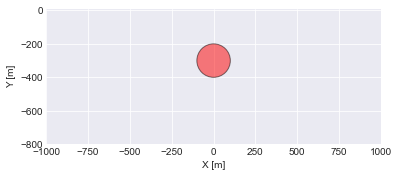

In [10]:
plt.style.use('seaborn-darkgrid')
ax = plt.subplot(aspect='equal') 

# create circle object as matplotlib patch
circle1 = plt.Circle((0, -sphere_center), sphere_radius, 
                     facecolor='r', edgecolor='k', alpha=0.5)

ax.add_artist(circle1)

# set model domain
ax.set_xlim([-1000,1000])
ax.set_ylim([-800,10])

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
plt.savefig('./Simple_grav_img/SG_noise_3_para/model.png')

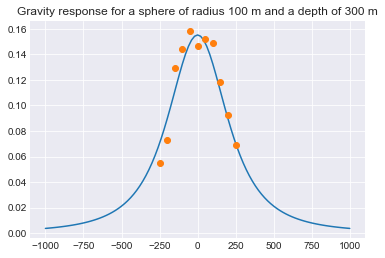

In [11]:
plt.plot(x_domain, grav_all)
plt.plot(x_obs, grav_obs_array_noise, 'o', label="data")
plt.title("Gravity response for a sphere of radius 100 m and a depth of 300 m");
plt.savefig('./Simple_grav_img/SG_noise_3_para/gravity.png')

### NEW

Bayes’s Theorem

\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \pi_{\mathrm{like}}\left(\mathbf{d}_{\mathrm{obs}} | \mathrm{m}\right) \mathrm{d} \mu_{\mathrm{prior}}(\mathrm{m})
\end{equation}

Prior
\begin{equation}
\mu_{\text {prior }} \sim \mathcal{N}\left(m_{\text {prior }}, C_{\text {prior }}\right)
\end{equation}

In [12]:
mu_prior = [250., 450., 100.]
mu_prior = tf.convert_to_tensor(mu_prior)

The likelihood
\begin{equation}
\mathbf{d}_{\mathrm{obs}}=\mathbf{f}(\mathrm{m})+\mathbf{e}, \quad \mathbf{e} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{\Gamma}_{\mathrm{noise}}\right)
\end{equation}
\begin{equation}
\pi_{\text {like }}\left(\mathbf{d}_{\text {obs }} | \mathrm{m}\right)=\exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}\right)
\end{equation}

In [13]:
## initial guess

mu = tf.get_variable("mu", dtype=tf.float32,
  initializer=tf.constant([280., 470., 120.]))
# true = [300., 500., 100.]


In [14]:
x_obs

array([-250., -200., -150., -100.,  -50.,    0.,   50.,  100.,  150.,
        200.,  250.])

In [15]:
# Defind f(m). Here f is the parameter-to-observable map that takes a 
# parameter m and maps it to the space observation vector dobs.

def grav_analytical_tf(x, mu, cov):
    # [sphere_center, density_difference, sphere_radius]

    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    
    gravity = tf.reduce_sum(((4/3)*np.pi * (sphere_radius**3) * density_difference* G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 ,keepdims=True)

    
    return gravity



### Gradient decent to find MAP (?)

In [16]:
import tensorflow.math as tm

## function compute G^T C^-1 G

def matrixcompute(matrix1,matrix2,Cov):
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(tf.constant(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    
    return result

\begin{equation}
\pi_{\text {like }}\left(\mathbf{d}_{\text {obs }} | \mathrm{m}\right)=\exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}\right)
\end{equation}

#### The posterior


\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\mathrm{\Gamma}_{\mathrm{noise}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}\right)
\end{equation}

#### negative log of the posterior
\begin{equation}
\left(\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\mathrm{\Gamma}_{\mathrm{noise}}^{-1}}^{2}+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}\right)
\end{equation}


term 1
\begin{equation}
\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}
\end{equation}

In [17]:
grav_obs_array_noise_sum = tf.convert_to_tensor(grav_obs_array_noise_sum,dtype=tf.float32)

In [18]:
cov = [[ 20.,  0.,  0.],
        [ 0.,  20., 0.],
        [ 0., 0.,  20.]]
cov = tf.convert_to_tensor(cov)

term 2
\begin{equation}
\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}
\end{equation}


In [19]:
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    grav = grav_analytical_tf(x_obs,mu, cov)
    term_1 = matrixcompute(grav,grav_obs_array_noise_sum,noise_tensor)
    term_2 = matrixcompute(mu,mu_prior,cov)
    Negtive_log_likelihood = tf.add(term_1,term_2)
    
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train = optimizer.minimize(Negtive_log_likelihood)
    log_tem = session.run(Negtive_log_likelihood) 
    
    print("starting at", "mu:", session.run(mu), "negative log likelihood:", session.run(Negtive_log_likelihood))
    for step in range(100):  
        session.run(train)
        log_tem_new = session.run(Negtive_log_likelihood)
       ## Find and save MAP point 
        if log_tem_new < log_tem:
            log_tem = log_tem_new
            MAP = session.run(mu)
        
        print("step", step, "mu:", session.run(mu), "negative log likelihood:",log_tem_new )


    

W0920 15:48:18.109920 4548249024 deprecation.py:323] From /Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


starting at mu: [280. 470. 120.] negative log likelihood: [[2189.1072]]
step 0 mu: [280.77167 469.6879  116.25263] negative log likelihood: [[1309.6626]]
step 1 mu: [281.5774  469.35315 112.36722] negative log likelihood: [[5877.167]]
step 2 mu: [282.1993  469.0941  109.29414] negative log likelihood: [[414.1142]]
step 3 mu: [282.62506 468.90744 107.08226] negative log likelihood: [[374.02313]]
step 4 mu: [282.6193  468.8937  107.01982] negative log likelihood: [[417.10703]]
step 5 mu: [282.76566 468.81937 106.15859] negative log likelihood: [[37.814117]]
step 6 mu: [283.16772 468.6454  104.06949] negative log likelihood: [[36.67288]]
step 7 mu: [283.13    468.64447 104.18777] negative log likelihood: [[176.62521]]
step 8 mu: [283.17712  468.60977  103.838356] negative log likelihood: [[61.127594]]
step 9 mu: [283.12473 468.61456 104.0416 ] negative log likelihood: [[190.31992]]
step 10 mu: [283.28906 468.5321  103.09105] negative log likelihood: [[102.10045]]
step 11 mu: [283.25342 46

#### Least Square solution (TO DO)

## pCN MCMC

In [20]:
MAP = tf.convert_to_tensor(MAP)

In [21]:
def compute_hessian(fn, vars):
    mat = []
    for v1 in vars:
        temp = []
        for v2 in vars:
            # computing derivative twice, first w.r.t v2 and then w.r.t v1
            temp.append(tf.gradients(tf.gradients(fn, v2)[0], v1)[0])
        temp = [cons(0) if t == None else t for t in temp] # tensorflow returns None when there is no gradient, so we replace None with 0
        temp = tf.stack(temp)
        mat.append(temp)
    mat = tf.stack(mat)
    return mat
def cons(x):
    return tf.constant(x, dtype=tf.float32)

In [22]:
def grav_analytical_tf_hess(x, mu, cov):
    # [sphere_center, density_difference, sphere_radius]

    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    
    gravity = tf.reduce_sum(((4/3)*np.pi * (sphere_radius**3) * density_difference* G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 ,keepdims=True)
    
    hess = compute_hessian(gravity,[sphere_center,density_difference,sphere_radius])
    
    return gravity, hess



#### Compute the Hessian and Covariance of the Posterior

\begin{equation}
\mathcal{C}_{\mathrm{post}}=\left(\mathcal{H}_{\mathrm{misfit}}\left(m_{\nu}\right)+\mathcal{C}_{\mathrm{prior}}^{-1}\right)^{-1}
\end{equation}

In [23]:
grav, hess = grav_analytical_tf_hess(x_obs, MAP, cov)

In [24]:
Matrix_tem = tf.add(hess, tf.linalg.inv(cov))

C_post = tf.linalg.inv(Matrix_tem)

In [25]:
with tf.Session() as session:
    print('hessian matrix at MAP: \n', session.run(hess))
    print('Covariance of the Prior: \n',session.run(cov))
    print('Covariance of the Posterior: \n',session.run(C_post))

hessian matrix at MAP: 
 [[ 5.7157064e-05 -1.5915131e-05 -2.1667525e-04]
 [-1.5915130e-05  0.0000000e+00  8.6971530e-05]
 [-2.1667527e-04  8.6971530e-05  7.8937807e-04]]
Covariance of the Prior: 
 [[20.  0.  0.]
 [ 0. 20.  0.]
 [ 0.  0. 20.]]
Covariance of the Posterior: 
 [[ 1.9979927e+01  5.4884870e-03  7.9381719e-02]
 [ 5.4884865e-03  2.0000051e+01 -3.1535368e-02]
 [ 7.9381712e-02 -3.1535368e-02  1.9698383e+01]]


#### define whether to accept or reject the new sample
\begin{equation}
\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)=\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\Gamma_{\mathrm{noise}}^{-1}}
\end{equation}

\begin{equation}
a\left(m_{\text {current }}, m_{\text {proposed }}\right) :=\min \left\{1, \exp \left(\Phi\left(m_{\text {current }}, \mathbf{d}_{\text {obs }}\right)-\Phi\left(\mathrm{m}_{\text {proposed }}, \mathbf{d}_{\text {obs }}\right)\right)\right\}
\end{equation}

In [26]:
# ### Test: this should be accepted always
# m_current = tf.get_variable("m_current", dtype=tf.float32,
#   initializer=tf.constant([280., 470., 120.]))

# m_proposed = tf.get_variable("m_proposed", dtype=tf.float32,
#   initializer=tf.constant([300., 500., 100.]))

In [27]:
### Test: this should be accepted always
m_current = tf.get_variable("m_current", dtype=tf.float32,
  initializer=tf.constant([300., 500., 100.]))
m_proposed = tf.get_variable("m_proposed", dtype=tf.float32,
  initializer=tf.constant([0., 0., 0.]))

In [28]:

grav_current = grav_analytical_tf(x_obs,m_current, cov)
phi_current = matrixcompute(grav_current,grav_obs_array_noise_sum,noise_tensor)

grav_proposed = grav_analytical_tf(x_obs,m_proposed, cov)
phi_proposed = matrixcompute(grav_proposed,grav_obs_array_noise_sum,noise_tensor)


@tf.function
def acceptance_pCN(phi_current , phi_proposed):

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(phi_current,phi_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    ## greater : further away from the observation = less possible to accept
    then_expression = tf.greater_equal( phi_current,phi_proposed)
    else_expression = tf.greater(accept_ratio, sample)
    
    
    condition = tf.reshape(tf.greater_equal( phi_current,phi_proposed),())
    
    
    x = tf.cond(condition ,
               lambda: then_expression,
               lambda: else_expression)
    
    x = tf.reshape(x,())
    return x
        



In [29]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(acceptance_pCN(phi_current , phi_proposed)))

False


#### gpCN

gpCN is a generalized version of the pCN sampler. While the proposals of pCN are drown from the prior Gaussian distribution $\mu_{prior}$,proposals in the generalized pCN are drown from a Gaussian approximation $v$ of the posterior distribution.

\begin{equation}
a_{\nu}\left(m_{\mathrm{current}}, m_{\mathrm{proposed}}\right) :=\min \left\{1, \exp \left(\Delta\left(m_{\mathrm{current}}\right)-\Delta\left(m_{\mathrm{proposed}}\right)\right)\right\}
\end{equation}

where   

\begin{equation}
\Delta(m)=\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\nu}\right\|_{\mathrm{C}_{\nu}^{-1}}^{2}
\end{equation}

In [30]:
# grav_current = grav_analytical_tf(x_obs,m_current, cov)
# phi_current = matrixcompute(grav_current,grav_obs_array_noise_sum,noise_tensor)

# grav_proposed = grav_analytical_tf(x_obs,m_proposed, cov)
# phi_proposed = matrixcompute(grav_proposed,grav_obs_array_noise_sum,noise_tensor)


# t2_current = matrixcompute(m_current,mu_prior,cov)
# t3_current = matrixcompute(m_current,MAP,C_post)

# t2_proposed = matrixcompute(m_proposed,mu_prior,cov)
# t3_proposed = matrixcompute(m_proposed,MAP,C_post)

# delta_current = tf.subtract(tf.add(phi_current,t2_current ),t3_current)
# delta_proposed = tf.subtract(tf.add(phi_proposed,t2_proposed ),t3_proposed)

# ## calculate accept ratio if exp()<1
# accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
# acceptsample = tfd.Sample(
# tfd.Uniform(0., 1.),
# sample_shape=[1,1])
# sample = acceptsample.sample()

# ## greater : further away from the observation = less possible to accept
# then_expression = tf.greater_equal( delta_current,delta_proposed)
# else_expression = tf.greater(accept_ratio, sample)


# condition = tf.reshape(tf.greater_equal( delta_current,delta_proposed)[0],())

# x = tf.cond(condition ,
#                lambda: then_expression,
#                lambda: else_expression)

# init = tf.global_variables_initializer()
# with tf.Session() as sess:
#     sess.run(init)
#     print(sess.run(then_expression))

[[False]]


In [37]:

@tf.function
def acceptance_gpCN(m_current , m_proposed):
    
    grav_current = grav_analytical_tf(x_obs,m_current, cov)
    phi_current = matrixcompute(grav_current,grav_obs_array_noise_sum,noise_tensor)

    grav_proposed = grav_analytical_tf(x_obs,m_proposed, cov)
    phi_proposed = matrixcompute(grav_proposed,grav_obs_array_noise_sum,noise_tensor)


    t2_current = matrixcompute(m_current,mu_prior,cov)
    t3_current = matrixcompute(m_current,MAP,C_post)

    t2_proposed = matrixcompute(m_proposed,mu_prior,cov)
    t3_proposed = matrixcompute(m_proposed,MAP,C_post)

    delta_current = tf.subtract(tf.add(phi_current,t2_current ),t3_current)
    delta_proposed = tf.subtract(tf.add(phi_proposed,t2_proposed ),t3_proposed)

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    
    ## greater : further away from the observation = less possible to accept
    then_expression = tf.greater_equal( delta_current,delta_proposed)
    else_expression = tf.greater(accept_ratio, sample,name = 'shit')
    
    condition = tf.reshape(tf.greater_equal( delta_current,delta_proposed)[0],())
    

    x = tf.cond(condition ,
               lambda: then_expression,
               lambda: else_expression)
    
    x = tf.reshape(x,())
    return x
        

In [42]:

init = tf.global_variables_initializer()
with tf.Session() as sess:
    
    sess.run(init)
    print(sess.run(acceptance_gpCN(m_current , m_proposed)))
    
#     i = 1
#     for i in range (1000):
#         print(sess.run(acceptance_gpCN(m_current , m_proposed, sess)))

False


#### Proposal

\begin{equation}
v^{(k)}=m_{\nu}+\sqrt{1-\beta^{2}}\left(m^{(k)}-m_{\nu}\right)+\beta \xi^{(k)}, \quad \xi^{(k)} \sim \mathcal{N}\left(0, \mathcal{C}_{\nu}\right)
\end{equation}

In [120]:
beta = 0.7
Xi = tfd.MultivariateNormalFullCovariance(
        loc = 0,
        covariance_matrix= C_post)

Xi_s = tfd.Sample(X)
_term3 = tf.multiply(beta,Xi_s.sample())

_term3

<tf.Tensor 'Mul_49:0' shape=(3,) dtype=float32>

In [138]:
# define leaning rate
beta = 0.7

@tf.function
def draw_proposal(m_current):
    
    tem_1 = tf.convert_to_tensor(np.sqrt(1-beta**2),dtype = tf.float32)
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= C_post)

    Xi_s = tfd.Sample(X)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(tf.add(m_current,_term2),_term3)
    
    return m_proposed
    
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(draw_proposal(m_current)))
    

[311.21115 522.798    98.96062]


### Chain

In [147]:
def run_chain():
    steps = 10000
    k = 0
    accepted = []
    rejected = []

    m_current = mu  # init m
    
    
    for k in range(steps):

        m_proposed = sess.run(draw_proposal(m_current))

        if sess.run(acceptance_gpCN(:
            m_current = m_proposed
            accepted.append(m_proposed)
        else:
            m_current = m_current
            rejected.append(m_current)
    
    return accepted
    


In [148]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    sess.run(run_chain())
    
    
    

KeyboardInterrupt: 

In [49]:
def foo(sess):
    a = tf.Variable(1)
    print(sess.run(a))

In [50]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    foo(sess)
    sess.run(init)

FailedPreconditionError: Attempting to use uninitialized value Variable_3
	 [[{{node _retval_Variable_3_0_0}}]]